# Can we recover MNIST clusters from mixed Fashion MNIST data?

As we saw in [our analysis of the mixed images](AnalyzeMixedImages.ipynb), simply embedding the image data using a standard algorithm does not help to reveal the individual digit categories.  If a scenario where only the mixed data were provided, it would be much harder to determine that there are distinct digit classes underlying this data.

We would like to explore possible techniques for extracting and visualizing the MNIST manifold hidden within this mixed data.

In [1]:
%%capture

import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import DataUtils as DU

import cache_magic # pip install ipython-cache

## Setup Code

In the cells below, we:

1. load the datasets,
2. synthesized the mixed data,
3. compute covariance matrices, and
4. compute the principal components.

The datasets are labeled as follows:

* `A` -- "pure" MNIST data
* `B` -- "noise" grass data
* `C` -- "mixed" data (80% grass; 20% MNIST)
* `D` -- second grass data set, independent samples with same distribution as `B`

In a realistic setting, we would only be given `C` and `D`.

Looking at the data and covariance structure of `A` and `B` can be instructive for devising a technique to "denoise" `C`,
however using either of these in the solution is "cheating".


In [2]:
mnist_img, mnist_lab = DU.load_data("data/mnist_70000.hdf5")
fashion_img, fashion_lab = DU.load_data("data/fashion_mnist_70000.hdf5")

In [3]:
NS = 60000
Aimg, Alab = mnist_img[:NS], mnist_lab[:NS]
Bimg, Blab = fashion_img[:NS], fashion_lab[:NS]
Cimg = Aimg * 0.2 + Bimg * 0.8
Dimg, Dlab = fashion_img[NS:], fashion_lab[NS:]

In [4]:
Agrouped = np.hstack([np.arange(NS)[Alab==i][:10] for i in range(10)])
Bgrouped = np.hstack([np.arange(NS)[Alab==i][:10] for i in range(10)])

In [5]:
A, Abar, Acov = DU.normalize_image_data(Aimg)
B, Bbar, Bcov = DU.normalize_image_data(Bimg)
C, Cbar, Ccov = DU.normalize_image_data(Cimg)
D, Dbar, Dcov = DU.normalize_image_data(Dimg)

In [6]:
Au, As, Avt = np.linalg.svd(Acov)
Bu, Bs, Bvt = np.linalg.svd(Bcov)
Cu, Cs, Cvt = np.linalg.svd(Ccov)
Du, Ds, Dvt = np.linalg.svd(Dcov)

## Experiment 1: Reuse the MNIST PCs (Cheating!)

Let's start by imagining that we already know what the MNIST digits are supposed to look like.  If we knew this, we could try to massage the mixed data by projecting it into the first 50-100 PCs of MNIST (dataset `A`).  This might help to uncover the signal we're looking for.

As a reminder, here are the first 10 PCs of MNIST:

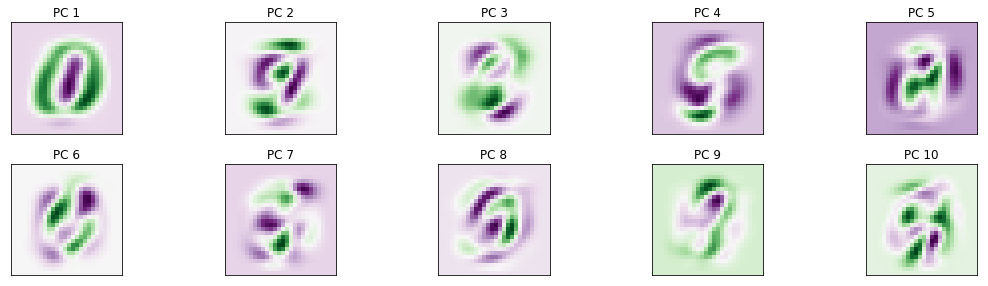

In [7]:
DU.show_pcs(Au, 10)

And this is the result of projecting the mixed images using the first 100 PCs of MNIST:

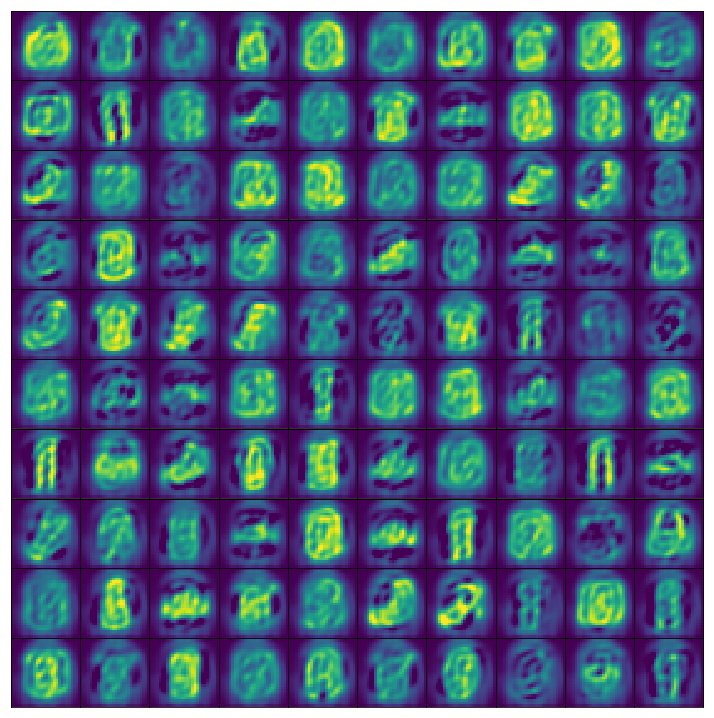

In [8]:
DU.show_data(DU.X_to_img(C[Agrouped] @ Au[:,0:50] @ Au[:,0:50].T, Cbar), cols=10)

**Observations:**

1. Some digit forms are visible, however they are not especially clear.
2. There is a lot of visual clutter around each digit where portions of the grass texture have projected onto the principal components of the digits.
3. The average background intensity in the digit area is not uniform.

This clutter and nonuniform intensity are likely to interfere with detection of the manifold.

We can confirm that projecting into this subspace only does a limited amount of work in revealing the MNIST manifold by embedding with UMAP:

loading cached value for variable 'umap_mixed_mnist_fashion_pca50'. Time since pickling  0:09:59.493114


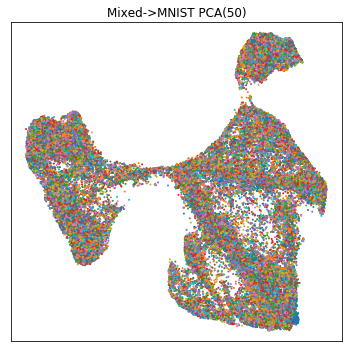

In [9]:
%cache umap_mixed_mnist_fashion_pca50 = DU.umap_embedding(C @ Au[:,0:50])

DU.show_embeddings([umap_mixed_mnist_fashion_pca50], titles=["Mixed->MNIST PCA(50)"], labels=Alab)

**Observations:**

1. The embedding does reveal some spatial coherence amongst the digits, but
2. these regions are elongated and have overlapping boundaries.

This suggests that there are some very strong directions remaining in the data which are not useful for identifying digits.

If we can eliminate these directions from the data, we may be able to improve the image.

## Experiment 2: Remove "Background" PCs from Data

From [our earlier investigation of the grass dataset](AnalyzeGrassData.ipynb), we know that the first few PCs explain half of the variance.

Perhaps we can remove these PCs from the mixed data to obtain a "better" result?

Since grass data `D` has the same distribution as `B`, we should be able to do this by projecting the mixed data into the null space of `PCA(D, k)`.

The PCs of `D` are virtually identical to those of `B`, and look like this:

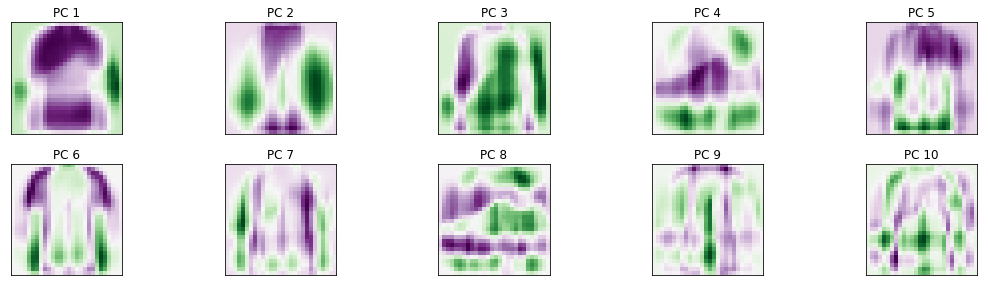

In [10]:
DU.show_pcs(Du, 10)

**Observations:**

* The first three PC correspond (roughly) to:

  1. average image intensity
  2. vertical gradient
  3. horizontal gradient


* PC 4 (and beyond) are more suspicious because these focus on more specific areas and could interfere with digit recognition.

We will start conservatively, by removing only the first three principal components.

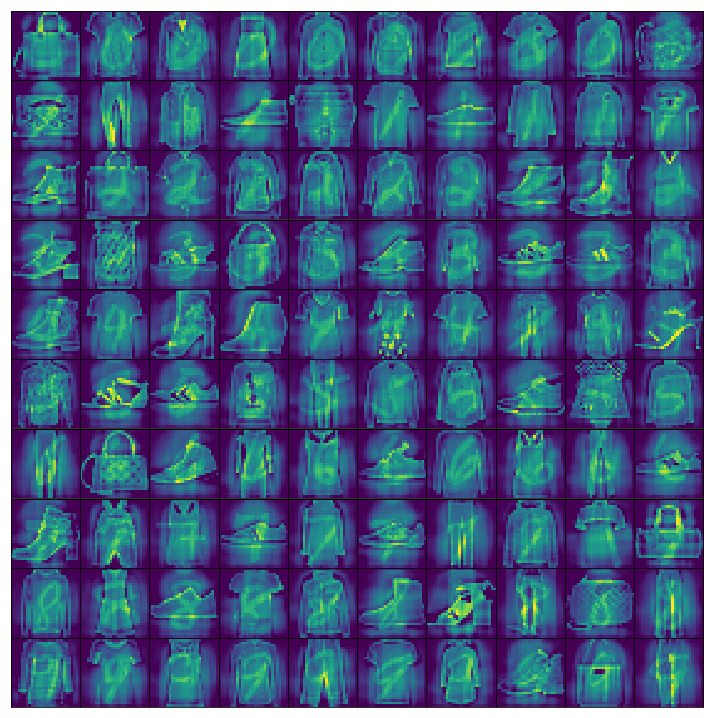

In [11]:
DU.show_data(DU.X_to_img(C[Agrouped] @ Du[:,20:] @ Du[:,20:].T, Cbar), cols=10)

**Observations:**

1. Removing the first few components of `D` has controlled for variations in image intensity and simple gradients.
2. Most digits still appear to be on a strong textured background.
3. None of the first 10 grass PCs are likely to remove this strong background, as they are all too coarse.

Strong textures are likely to interfere with our ability to detect the manifold.

We examine the umap embedding next:

loading cached value for variable 'umap_mixed_mnist_fashion_sub20'. Time since pickling  0:07:57.685985


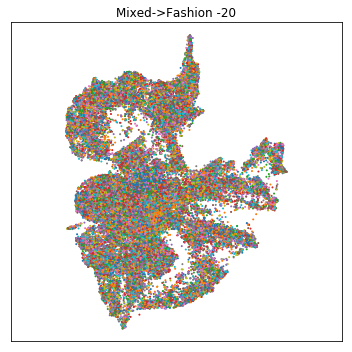

In [12]:
%cache umap_mixed_mnist_fashion_sub20 = DU.umap_embedding(C @ Du[:,20:])

DU.show_embeddings([umap_mixed_mnist_fashion_sub20], titles=["Mixed->Fashion -20"], labels=Alab)

And here, we see a much more promising sign.

Despite the textured background, the shear preponderance of data has allowed us to uncover a rough, noisy version of the MNIST manifold.

Can we do better?

## Experiment 3: Remove background and reduce dimension

Continuing from experiment 2, what if we were to remove the background and reduce the dimension further via PCA?

Here, we build a covariance matrix from the projected data in Experiment 2 and compute the SVD:

In [13]:
CX20 = C @ Du[:,20:] @ Du[:,20:].T
CX20cov = CX20.T @ CX20
CX20u, CX20s, CX20vt = np.linalg.svd(CX20cov)

We can examine the first 10 principal components of this data.

### PCs 1-10 of Reduced Data

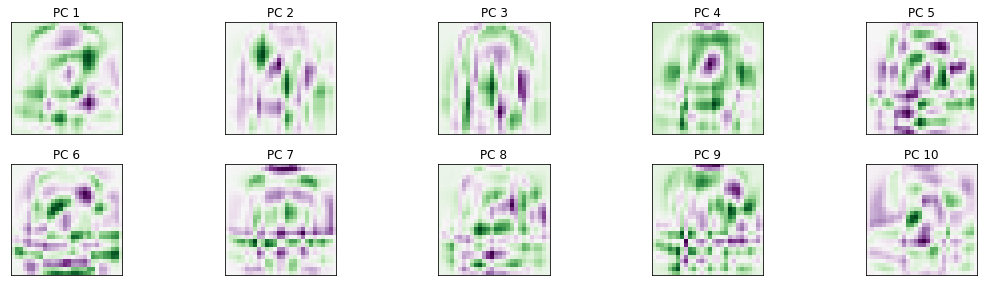

In [14]:
DU.show_pcs(CX20u, 10)

### PC 1-10 of MNIST

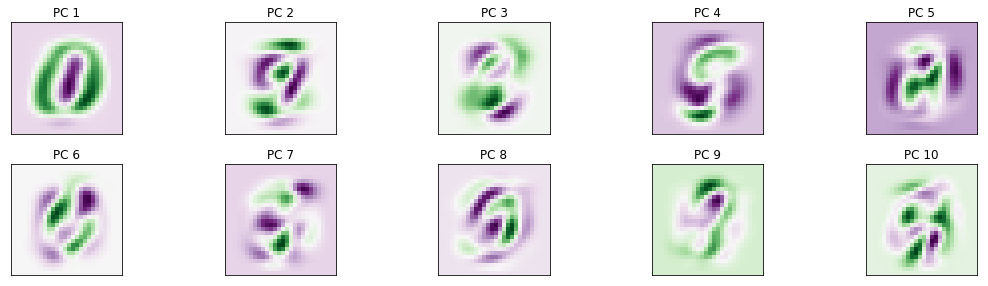

In [15]:
DU.show_pcs(Au, 10)

**Observations:**

1. PCs 1-5 are very similar to those in MNIST.
2. Subsequent PCs differ somewhat more.

Next, we examine the images when reduced to the first 50 PCs:

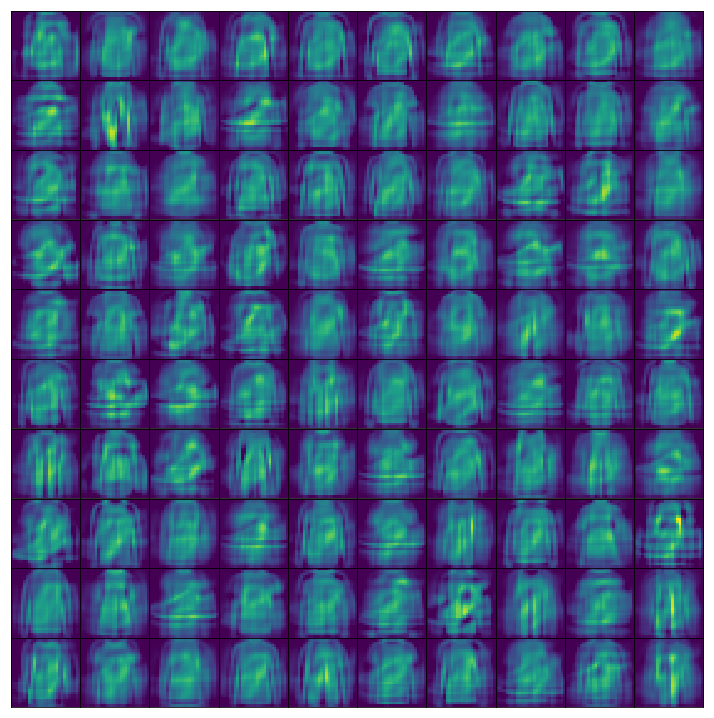

In [16]:
DU.show_data(DU.X_to_img(CX20[Agrouped][:100] @ CX20u[:,:50] @ CX20u[:,:50].T, Cbar), cols=10)

**Observations**

1. Limiting the data to 50 PCA dimensions has resulted in blurrier images.
2. This has consequentially reduced the impact of sharp background textures.

Next, we examine the UMAP embedding:

loading cached value for variable 'umap_mixed_mnist_fashion_sub20_pca50'. Time since pickling  0:05:20.572430


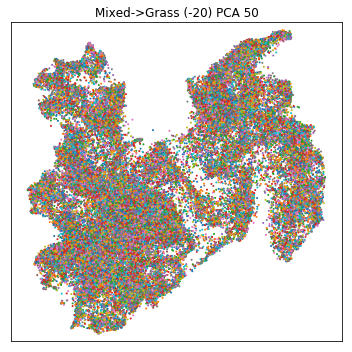

In [17]:
%cache umap_mixed_mnist_fashion_sub20_pca50 = DU.umap_embedding(CX20 @ CX20u[:,:50])

DU.show_embeddings([umap_mixed_mnist_fashion_sub20_pca50], titles=["Mixed->Grass (-20) PCA 50"], labels=Alab)

**Observations**

1. Some clusters are now much better separated from the group.
2. Clutter has been somewhat reduced.

**Can we do better?**

## Experiment 4: Contrastive PCA

A recent paper in Nature Communications describes a technique called [Contrastive PCA](https://www.nature.com/articles/s41467-018-04608-8).  It presents a simple mechanism for discovering a subspace of "contrastive" principal components which explain as much of the signal variance and as little of the background variance as possible.

In Contrastive PCA, we compute a new covariance-like matrix as the difference between the mixed signal covariance and the background covariance:

$$ \Sigma^* = \Sigma_{X} - \alpha \Sigma_{Y} $$

where:

* $\Sigma^*$ is the contrastive "covariance" matrix,
* $\Sigma_{X}$ is the covariance of the mixed signal,
* $\Sigma_{Y}$ is the covariance of a "background" sample, and
* $\alpha$ is a parameter which allows exploring the frontier of contrasting principal components.

This leaves us with the task of determining a good value for the parameter $\alpha$.

We know that when:

* $\alpha = 0$, $\Sigma^* = \Sigma_{X}$ (i.e. same as PCA on the mixed signal)
* $\alpha = \inf$, $\Sigma^* \propto \Sigma_{Y}$ (i.e. same components as the background signal)

However, based on our mixing model, we can also determine another value for $\alpha$, as follows.

### Solving for $\alpha$

Given two distributions, $S$ and $T$, where:

* $\bar{S} = \bar{T} = 0$ (i.e. zero mean), and
* $S^T T = T^T S = 0$ (i.e. independence),

then we can write a mixture $R$ as:

$$ R = \gamma S + (1 - \gamma) T $$

We can write the covariance of $R$ as:

$$ \Sigma_R = R^T R = (\gamma S + (1 - \gamma) T)^T (\gamma S + (1 - \gamma) T) $$

Expanding, we get:

$$ \Sigma_R = \gamma^2 S^T S + (1 - \gamma) \gamma T^T S + \gamma (1 - \gamma) S^T T + (1 - \gamma)^2 T^T T $$

Assuming independence of $S$ and $T$, we can drop the cross terms to get:

$$ \Sigma_R = \gamma^2 S^T S + (1 - \gamma)^2 T^T T $$

Rewriting, $\Sigma_S = S^T S$ and $\Sigma_T = T^T T$, we get:

$$ \Sigma_R = \gamma^2 \Sigma_S + (1 - \gamma)^2 \Sigma_T $$

Solving for $\Sigma_S$ gives:

$$ \Sigma_S = {1 \over \gamma^2} (\Sigma_R - (1 - \gamma)^2 \Sigma_T) $$

Ignoring the coefficient ${1 \over \gamma^2}$, we see:

$$ \Sigma_S \propto \Sigma_R - (1 - \gamma)^2 \Sigma_T $$

Notice that this has the same form as the Contrastive PCA covariance:

$$ \Sigma^* = \Sigma_{X} - \alpha \Sigma_{Y} $$

By equating the right hand sides of these equations, we get that:

$$ \alpha = (1 - \gamma)^2 $$

### Value of $\alpha$

Since we used $\gamma = 0.2$ in our mixing model, we see that $\alpha = 0.64$ is the corresponding parameter for contrastive PCA.

We know that when:

* $\alpha = 0$, $\Sigma^* = \Sigma_{X}$ (i.e. same as PCA on the mixed signal)
* $\alpha = (1 - \gamma)^2$, $\Sigma^* \propto \Sigma{X}$ (i.e. same components as the desired signal)
* $\alpha = \inf$, $\Sigma^* \propto \Sigma_{Y}$ (i.e. same components as the background signal)

So, $\alpha$ gives us a way to move between the components of the mixed signal, the foreground signal, and the background signal.

Going forward, we'll use $\alpha = 0.64$.


In [101]:
Xcpc0_64 = DU.get_cpcs(Ccov, Dcov, alpha=0.75)

### Contrastive PCs

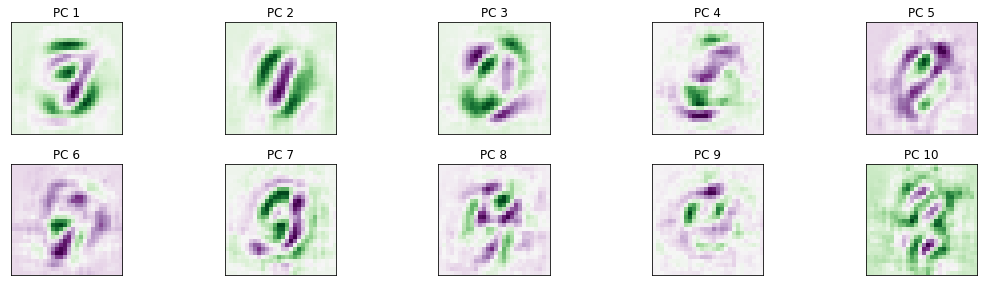

In [102]:
DU.show_pcs(Xcpc0_64, 10)

### MNIST PCs

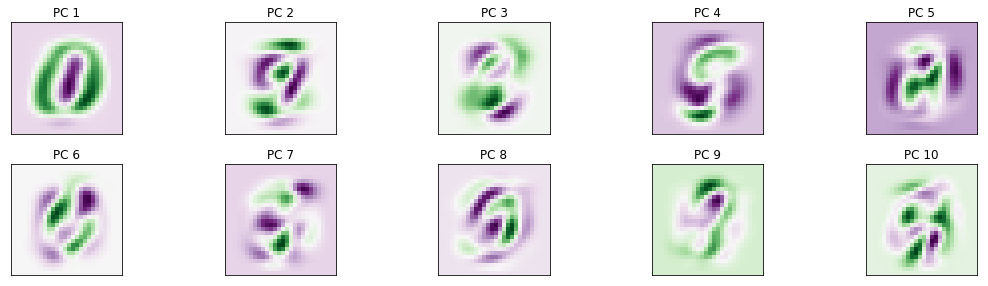

In [22]:
DU.show_pcs(Au, 10)

In [143]:
Au[:,8].T @ Xcpc0_64[:,20]

-0.10411985941519353

**Observations:**

1. The first 10 contrastive PCs are highly similar to the MNIST PCs, up to a sign flip.

This confirms that we are able to recover the MNIST PCs from the mixed signal without (cheating).

*(A small caveat is that we used the knowledge that $\gamma = 0.2$ to derive the value for $\alpha$.  However, it may be possible to determine this value in another way.)*


## Experiment 5: Use Contrastive PCs

Let's try projecting the mixed signal into contrastive PC space to see if we can better isolate the MNIST digit information.

Here are the digit images projected using the first 50 contrastive components:

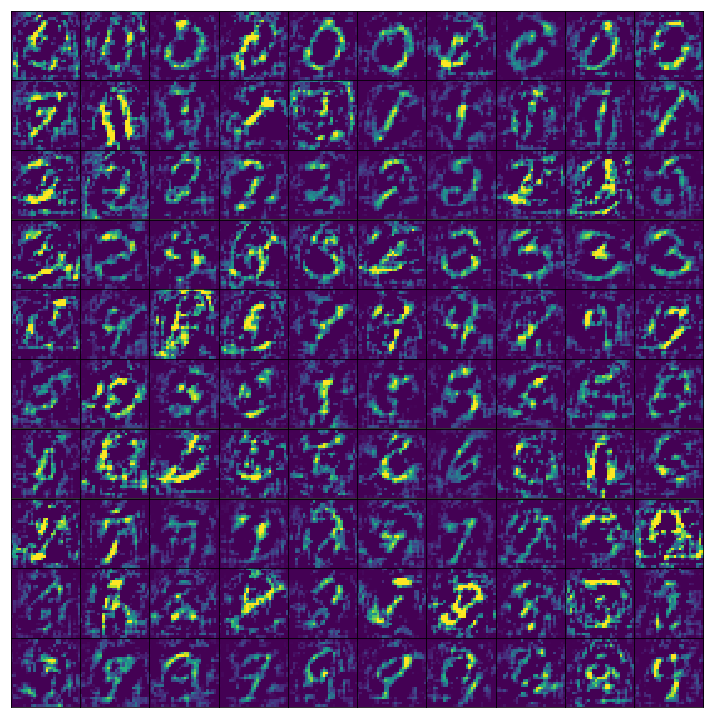

In [23]:
DU.show_data(DU.X_to_img(C[Agrouped] @ Xcpc0_64[:,:50] @ Xcpc0_64[:,:50].T * 5, 0), cols=10)

**Observations:**

1. Image backgrounds vary somewhat in average intensity.
2. There are some lines surrounding the digits.
3. The images are virtually identical to what we produced when we "cheated" and used the MNIST (i.e. pure signal) principal components. 

Here is the UMAP embedding when projecting the mixed data using the first 50 contrastive PCs:

resetting cached values for umap_mixed_mnist_fashion_cpca50_alpha0_64
creating new value for variable 'umap_mixed_mnist_fashion_cpca50_alpha0_64'


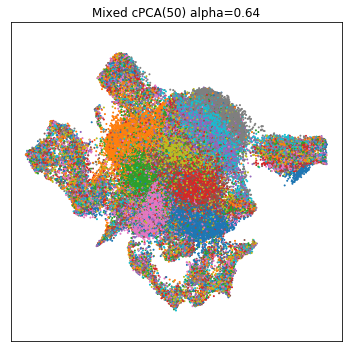

In [25]:
%cache umap_mixed_mnist_fashion_cpca50_alpha0_64 = DU.umap_embedding(C @ Xcpc0_64[:,:50])

DU.show_embeddings([umap_mixed_mnist_fashion_cpca50_alpha0_64], titles=["Mixed cPCA(50) alpha=0.64"], labels=Alab)

**Observations:**

1. Digit categories appear as long horizontal bands with overlapping edges.
2. This embedding is similar to what we obtained when using the MNIST PCs.

## Experiment 6: Explore $\alpha$ parameter

In [26]:
Xcpc1_10 = DU.get_cpcs(Ccov, Dcov, alpha=1.1)

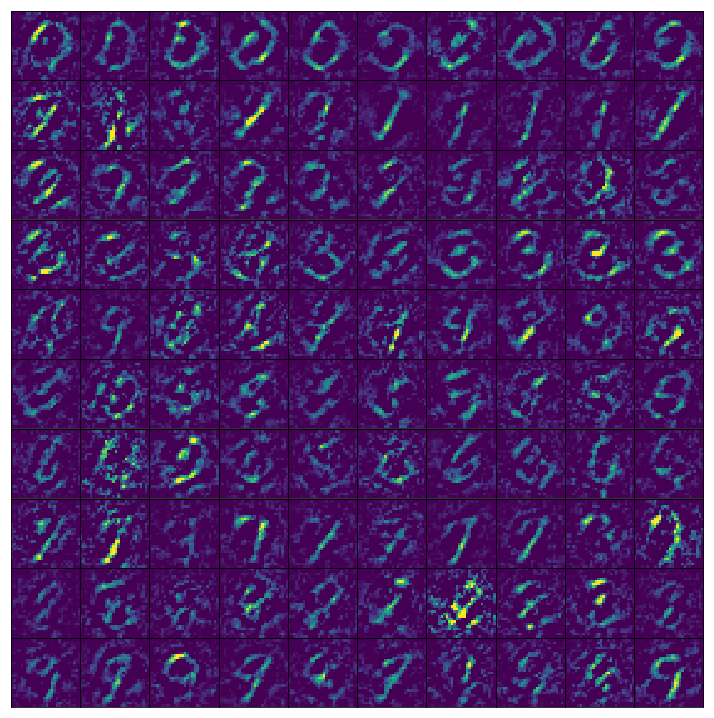

In [27]:
DU.show_data(DU.X_to_img(C[Agrouped] @ Xcpc1_10[:,:30] @ Xcpc1_10[:,:30].T * 5, 0), cols=10)

resetting cached values for umap_mixed_mnist_fashion_cpca50_alpha1_10
creating new value for variable 'umap_mixed_mnist_fashion_cpca50_alpha1_10'


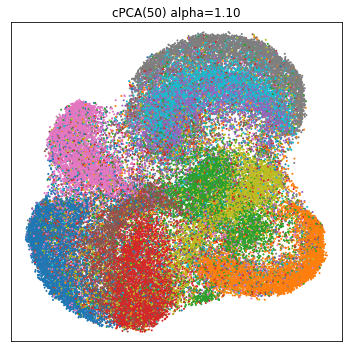

In [28]:
%cache umap_mixed_mnist_fashion_cpca50_alpha1_10 = DU.umap_embedding(C @ Xcpc1_10[:,:30])

DU.show_embeddings([umap_mixed_mnist_fashion_cpca50_alpha1_10], titles=["cPCA(50) alpha=1.10"], labels=Alab)

In [29]:
alphas = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]

In [30]:
Xcpcs_alphas = [DU.get_cpcs(Ccov, Dcov, alpha=a) for a in alphas]

In [31]:
%cache umap_mixed_mnist_fashion_cpcs_alphas = [DU.umap_embedding(C @ c[:,:30]) for c in Xcpcs_alphas]

resetting cached values for umap_mixed_mnist_fashion_cpcs_alphas
creating new value for variable 'umap_mixed_mnist_fashion_cpcs_alphas'


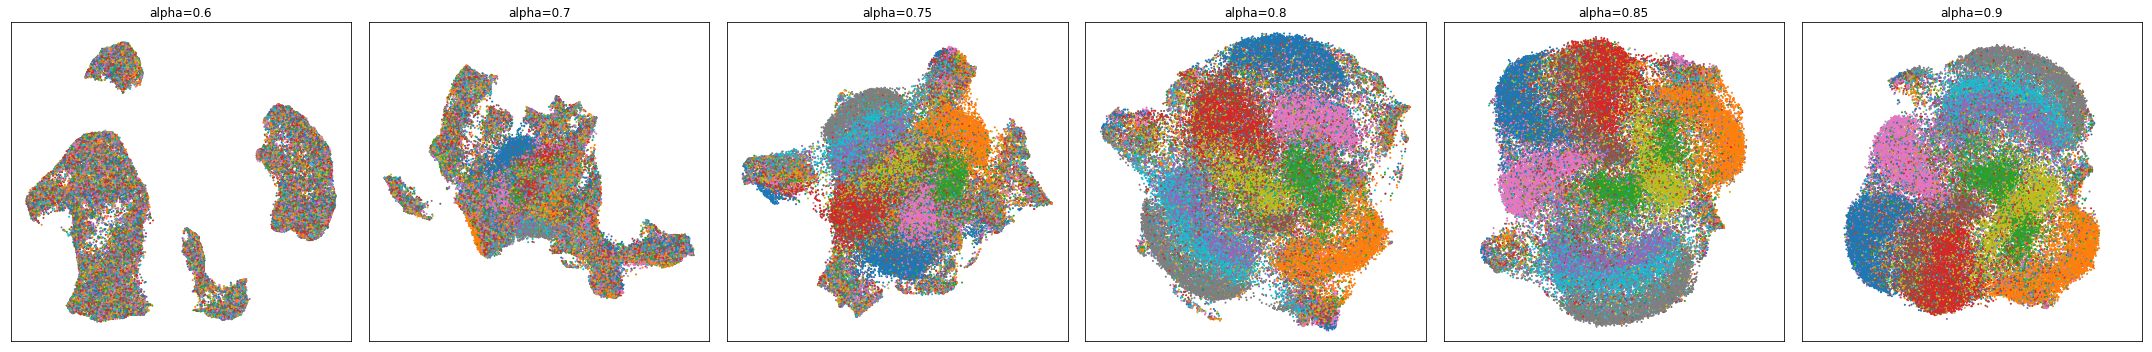

In [32]:
DU.show_embeddings(umap_mixed_mnist_fashion_cpcs_alphas, titles=["alpha={}".format(a) for a in alphas], labels=Alab)

## Experiment 8: Finding $\alpha_\mathrm{opt}$

In [ ]:
def getpcs(sigma, num):
    u, s, vt = np.linalg.svd(sigma)
    return u[:,:num].T

In [34]:
NP = 10
alphaspace = np.linspace(0.0, 2.0, 201)
%cache alphaspace_cpcs = np.array([DU.get_cpcs(Ccov, Dcov, a)[:,:NP].T for a in alphaspace])

resetting cached values for alphaspace_cpcs
creating new value for variable 'alphaspace_cpcs'


In [35]:
pcD = getpcs(Dcov, NP)
dotsD = abs(alphaspace_cpcs @ pcD.T)

pcA = getpcs(Acov, NP)
dotsA = abs(alphaspace_cpcs @ pcA.T)

Consider a subspace consisting of the first 10 principal components of the background $D$.  We can graph the PCs of the contrastive matrix $X(\alpha)$ in terms of their alignment (or orthogonality) with respect to this space, as we vary the parameter $\alpha$.

In particular, we will consider the dot product between a PC of $X(\alpha)$ as compared with each of the first 10 PCs of $D$.  Since all these vectors are unit normal, the values of the dot products will fall within $[-1, 1]$, however since we are interested in the degree of alignment, we will take the absolute value (with range $[0, 1]$).  The degree of alignment of a PC in $X$ will therefore be:

$$ \max_{i = 1 \ldots 10}{\| x \cdot U_i \|} $$


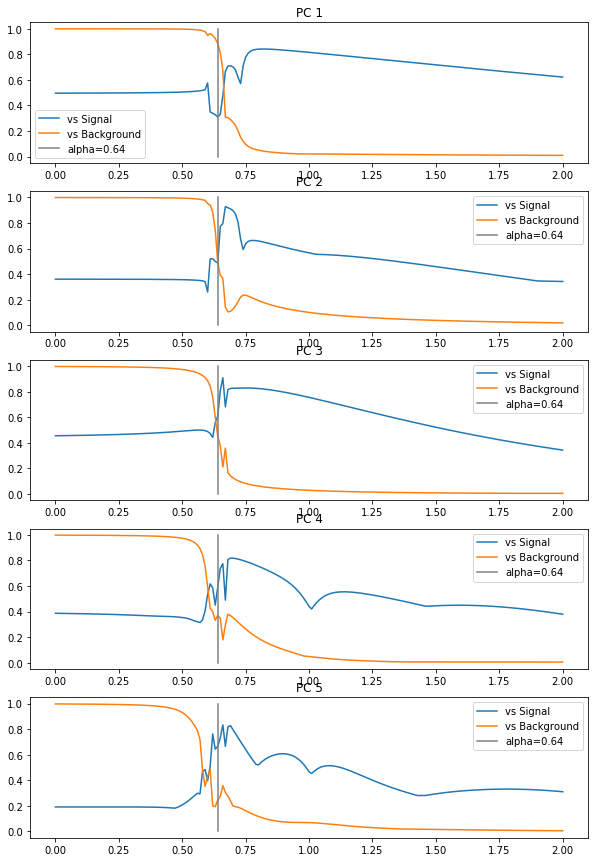

In [36]:
alpha = 0.64
plt.figure(figsize=(10,15))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(alphaspace, np.max(dotsA[:,i,:], axis=1), label="vs Signal".format(i+1))
    plt.plot(alphaspace, np.max(dotsD[:,i,:], axis=1), label="vs Background".format(i+1))
    plt.plot([alpha, alpha], [0.0, 1.0], label="alpha={}".format(alpha), c="grey")
    plt.legend()
    plt.title("PC {}".format(i+1))


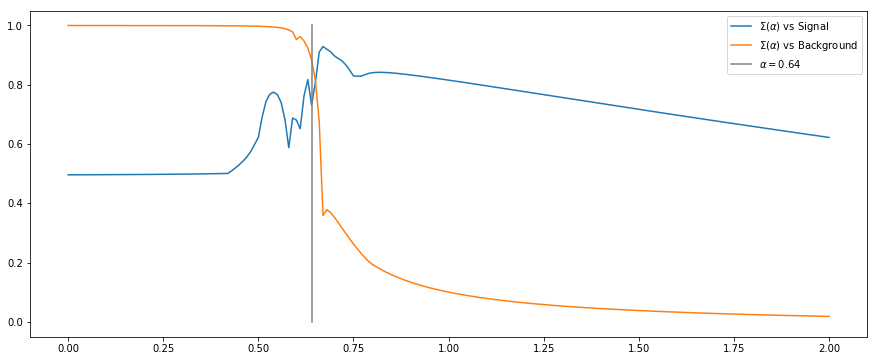

In [37]:
alpha = 0.64
plt.figure(figsize=(15,6))

maxdotA = np.max(dotsA, axis=(1,2))
plt.plot(alphaspace, maxdotA, label=r"$\Sigma(\alpha)$ vs Signal")

maxdotD = np.max(dotsD, axis=(1,2))
plt.plot(alphaspace, maxdotD, label=r"$\Sigma(\alpha)$ vs Background")

plt.plot([alpha, alpha], [0.0, 1.0], label=r"$\alpha={}$".format(alpha), c="grey")
plt.legend()

## Getting back to the mixture model

Based on the mixture model, 

$$ X = A + (1 - \gamma) B $$

we were able to find a relationship between $\gamma$ and $\alpha$ under the assumption that signal and background subspaces are independent, namely $\alpha = (1 - \gamma)^2$.

Reversing this equation, we can use the optimal value $\alpha_\mathrm{opt}$, and transform it to arrive at an estimate for the mixing coefficient, $\hat{\gamma}$, which indicates the relative strength of signal components as observed in the target data.  This quadratic relationship has roots at $\hat{\gamma} = 1 \pm \sqrt{\alpha_\mathrm{opt}}$.  The root at $1 + \sqrt{\alpha_\mathrm{opt}}$ can be ignored, since $\alpha_\mathrm{opt} > 1$ is outside the domain.

Therefore, with an empirical value of $\alpha_\mathrm{opt} = 0.6455$, we conclude that $\hat{\gamma} = 1 - \sqrt{0.6455} = 0.1965$, which is very close to the true value of $\gamma = 0.2$.


In [ ]:
%cache

In [76]:
def subspace_similarity(A, B):
    X = A @ B.T
    u, s, vt, = np.linalg.svd(X)
    return np.clip(s[0], 0.0, 1.0)

In [84]:
subspace_similarity(getpcs(Acov, 10), getpcs(Dcov,10))

0.9462444245403979

In [93]:
seriesA = [subspace_similarity(pcA[:5,:], a[:5,:]) for a in alphaspace_cpcs]
seriesD = [subspace_similarity(pcD[:5,:], a[:5,:]) for a in alphaspace_cpcs]

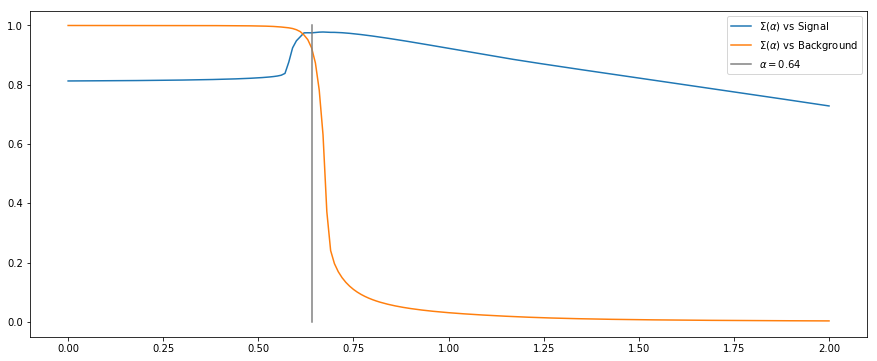

In [94]:
alpha = 0.64
plt.figure(figsize=(15,6))
plt.plot(alphaspace, seriesA, label=r"$\Sigma(\alpha)$ vs Signal")
plt.plot(alphaspace, seriesD, label=r"$\Sigma(\alpha)$ vs Background")
plt.plot([alpha, alpha], [0.0, 1.0], label=r"$\alpha={}$".format(alpha), c="grey")
plt.legend()